[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4448
[LightGBM] [Info] Number of data points in the train set: 8783, number of used features: 23
[LightGBM] [Info] Start training from score 0.296267
Validation MAE: 0.0806
Validation RMSE: 0.1113


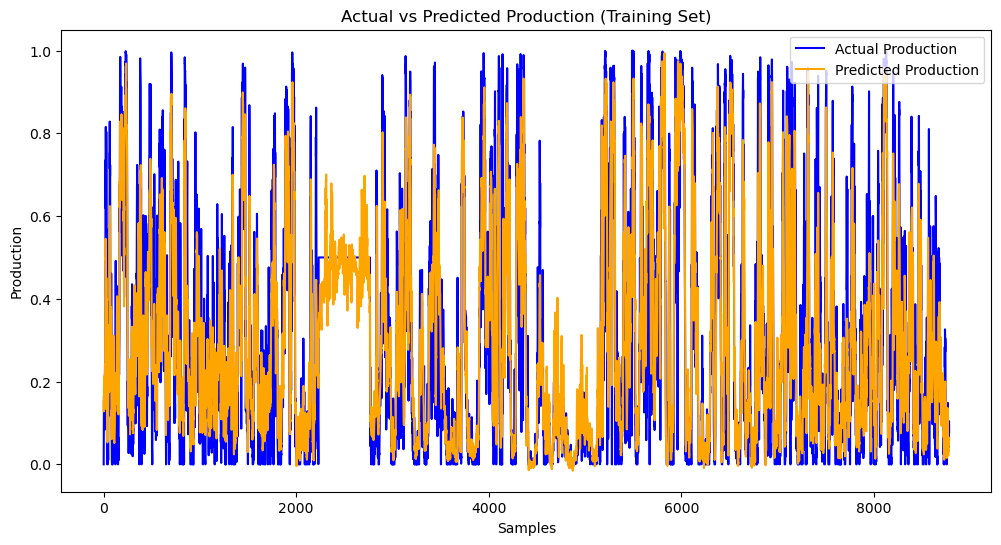

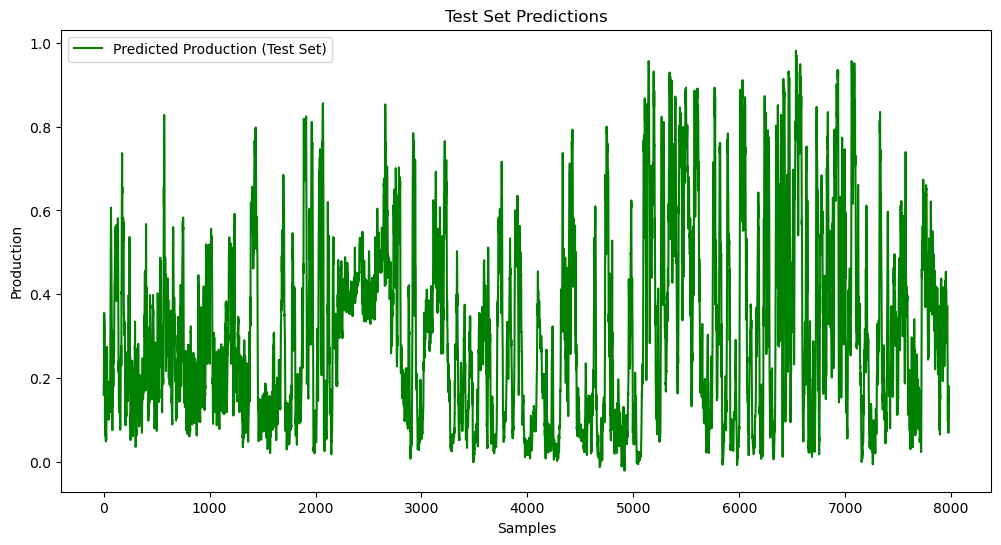

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from scipy.signal import butter, filtfilt

# Load the dataset
df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])

# Function to engineer basic cyclical features
def add_cyclical_features(data):
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
    data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    return data

# Exponential Weighted Moving Average (EWMA)
def add_ewma_features(data, columns, span=48):
    for column in columns:
        data[f'{column}_ewma_{span}'] = data[column].ewm(span=span).mean()
    return data

# Low-pass and Bandpass filters
def add_low_pass_filter(data, columns, cutoff=0.1, order=3):
    def butter_lowpass_filter(data, cutoff, fs=1.0, order=order):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    for column in columns:
        data[f'{column}_low_pass'] = butter_lowpass_filter(data[column].values, cutoff)
    return data

def add_bandpass_filter(data, columns, lowcut, highcut, fs=1.0, order=3):
    def butter_bandpass_filter(data, lowcut, highcut, fs, order):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data)
        return y
    for column in columns:
        data[f'{column}_band_pass'] = butter_bandpass_filter(data[column].values, lowcut, highcut, fs, order)
    return data


# Wind speed and direction engineering
for data in [df, test_df]:
    data['hour'] = data['date'].dt.hour
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek
    data = add_cyclical_features(data)
    data.drop(['hour','day','month','day_of_week'],axis=1,inplace=True)
    data['wind_speed_10m'] = np.sqrt(data['u10']**2 + data['v10']**2)
    data['wind_speed_100m'] = np.sqrt(data['u100']**2 + data['v100']**2)
    data['wind_direction_10m'] = np.degrees(np.arctan2(data['v10'], data['u10']))
    data['wind_direction_100m'] = np.degrees(np.arctan2(data['v100'], data['u100']))

# Apply filters 
df = add_ewma_features(df, columns=['wind_speed_10m', 'wind_speed_100m'], span=12)
df = add_low_pass_filter(df, columns=['wind_speed_10m', 'wind_speed_100m'], cutoff=0.1)
df = add_bandpass_filter(df, columns=['wind_speed_10m', 'wind_speed_100m'], lowcut=0.01, highcut=0.3)

# Apply filters
test_df = add_ewma_features(test_df, columns=['wind_speed_10m', 'wind_speed_100m'], span=12)
test_df = add_low_pass_filter(test_df, columns=['wind_speed_10m', 'wind_speed_100m'], cutoff=0.1)
test_df = add_bandpass_filter(test_df, columns=['wind_speed_10m', 'wind_speed_100m'], lowcut=0.01, highcut=0.3)

# Additional interaction and polynomial features
df['wind_speed_10m_squared'] = df['wind_speed_10m'] ** 2
df['wind_speed_100m_squared'] = df['wind_speed_100m'] ** 2
df['wind_direction_diff'] = df['wind_direction_10m'] - df['wind_direction_100m']

test_df['wind_speed_10m_squared'] = test_df['wind_speed_10m'] ** 2
test_df['wind_speed_100m_squared'] = test_df['wind_speed_100m'] ** 2
test_df['wind_direction_diff'] = test_df['wind_direction_10m'] - test_df['wind_direction_100m']

# Prepare features and target for training set
features = df.drop(columns=['production', 'date'])
target = df['production']
test_features = test_df.drop(columns=['date'])

# Filter columns to only include those present in both train and test sets
common_columns = features.columns.intersection(test_features.columns)
train_features = features[common_columns]
test_features = test_features[common_columns]

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_features.fillna(0))  # Training features with matching columns
scaled_test_features = scaler.transform(test_features.fillna(0))  # Test features with matching columns

# TimeSeries split with n=3
tscv = TimeSeriesSplit(n_splits=5)


base_params = {
    'learning_rate': 0.08,
    'num_leaves': 35,
    'max_depth': 18,
    'min_child_samples': 40,
    'subsample': 1,
    'subsample_freq': 9,
    'colsample_bytree': 0.95,
    'reg_alpha': 3,
    'reg_lambda': 0.3,
    'objective': 'regression',
    'metric': 'mae',
    
}

# Create and fit the model with best parameters
best_model = lgb.LGBMRegressor(**base_params)
best_model.fit(scaled_features, target)

# Predict on the training set (for validation purpose)
y_val_pred = best_model.predict(scaled_features)

# Evaluate the model on the training data (as no separate validation set was specified)
val_mae = mean_absolute_error(target, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(target, y_val_pred))
print(f'Validation MAE: {val_mae:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

# Predict on test data
y_test_pred = best_model.predict(scaled_test_features)

# Plot predictions on the training set
plt.figure(figsize=(12, 6))
plt.plot(target.values, label='Actual Production', color='blue')
plt.plot(y_val_pred, label='Predicted Production', color='orange')
plt.xlabel('Samples')
plt.ylabel('Production')
plt.legend()
plt.title('Actual vs Predicted Production (Training Set)')
plt.show()

# Plot test predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_pred, color='green', label='Predicted Production (Test Set)')
plt.xlabel('Samples')
plt.ylabel('Production')
plt.legend()
plt.title('Test Set Predictions')
plt.show()

In [23]:

# Save predictions to CSV
test_df = test_df.iloc[:len(y_test_pred)].copy()
test_df['production'] = y_test_pred
output_df = test_df[['date', 'production']]
output_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'
